In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
# set up the parameters of the class-conditioned Gaussian pdfs
mu_0 = np.array([-1, 1, -1, 1])
mu_1 = np.array([1, 1, 1, 1])

sigma_0 = np.array([[2, -0.5, 0.3, 0],
                    [-0.5, 1, -0.5, 0],
                    [0.3, -0.5, 1, 0],
                    [0, 0, 0, 2]])
sigma_1 = np.array([[1, 0.3, -0.2, 0],
                    [0.3, 2, 0.3, 0],
                    [-0.2, 0.3, 1, 0],
                    [0, 0, 0, 3]])

# set up the parameters of the class priors
p_0 = 0.7
p_1 = 0.3

In [3]:
# generate 10000 samples according to the data distribution
samples = 10000
x = np.random.multivariate_normal(mu_0, sigma_0, samples)
y = np.random.multivariate_normal(mu_1, sigma_1, samples)

# separate our final data set into data and labels
data = []
labels = []

# use the class priors to generate the labels
for i in range(samples):
    if np.random.rand() < p_0:
        data.append(x[i])
        labels.append(0)
    else:
        data.append(y[i])
        labels.append(1)

# convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [4]:
# set up the parameters of the loss matrix, using 0-1 loss
loss_matrix = np.array([[0, 1], [1, 0]])

### Part A
#### 1. Specify the minimum expected risk classification rule in the form of a likelihood ratio test where the threshold is a function of class priors and fixed loss values for each of the four possible outcomes

In [10]:
# return the ratio f_{X|Y}(x|1) / f_{X|Y}(x|0)
def likelihood_ratio_test(x: np.array, mu_0: np.array, mu_1: np.array, sigma_0: np.array, sigma_1: np.array) -> np.array:
    """
    Given a sample x, return the ratio f_{X|Y}(x|1) / f_{X|Y}(x|0)

    Args:
        x (np.array): a sample or samples from the data distribution
        mu_0 (np.array): the mean of the class 0 Gaussian pdf
        mu_1 (np.array): the mean of the class 1 Gaussian pdf
        sigma_0 (np.array): the covariance matrix of the class 0 Gaussian pdf
        sigma_1 (np.array): the covariance matrix of the class 1 Gaussian pdf

    Returns:
        np.array: the ratio f_{X|Y}(x|1) / f_{X|Y}(x|0)
    """
    ratios_x_0 = multivariate_normal.pdf(x, mean=mu_0, cov=sigma_0)
    ratios_x_1 = multivariate_normal.pdf(x, mean=mu_1, cov=sigma_1)
    return ratios_x_1 / ratios_x_0

In [11]:
# define the minimum expected risk classification rule
def minimum_expected_risk_classification_rule(x: np.array, threshold: float, mu_0: np.array, mu_1: np.array, sigma_0: np.array, sigma_1: np.array) -> np.array:
    """
    Given a sample x and a threshold, return the classification of x according to the minimum expected risk classification rule

    Args:
        x (np.array): a sample or samples from the data distribution
        mu_0 (np.array): the mean of the class 0 Gaussian pdf
        mu_1 (np.array): the mean of the class 1 Gaussian pdf
        sigma_0 (np.array): the covariance matrix of the class 0 Gaussian pdf
        sigma_1 (np.array): the covariance matrix of the class 1 Gaussian pdf
        threshold (float): the threshold for the likelihood ratio test

    Returns:
        np.array: the classification of x according to the minimum expected risk classification rule. 0 for class 0, 1 for class 1
    """
    ratios = likelihood_ratio_test(x, mu_0, mu_1, sigma_0, sigma_1)
    classifications = np.where(ratios >= threshold, 1, 0)
    return classifications

#### 2. Implement the classifier and apply it to the data set. Vary the threshold gradually from 0 to infinity and for each value of the threshold, compute the true positive rate and the false positive probabilities. Using these paired values, plot the ROC curve.

In [12]:
# obtain the true positive rate and false positive rate for each threshold for the ROC curve
def ROC_curve(data: np.array, labels: np.array, thresholds: np.array, mu_0: np.array = mu_0, mu_1: np.array = mu_1, sigma_0: np.array = sigma_0, sigma_1: np.array = sigma_1) -> tuple[np.array, np.array]:
    """
    Given data, labels, and thresholds, return the true positive rates and false positive rates for the ROC curve

    Args:
        data (np.array): the data set
        labels (np.array): the labels for the data set
        thresholds (np.array): the thresholds for the likelihood ratio test
        mu_0 (np.array, optional): the mean of the class 0 Gaussian pdf. Defaults to mu_0.
        mu_1 (np.array, optional): the mean of the class 1 Gaussian pdf. Defaults to mu_1.
        sigma_0 (np.array, optional): the covariance matrix of the class 0 Gaussian pdf. Defaults to sigma_0.
        sigma_1 (np.array, optional): the covariance matrix of the class 1 Gaussian pdf. Defaults to sigma_1.

    Returns:
        tuple[np.array, np.array]: the true positive rates and false positive rates for the ROC curve
    """
    # compute the predicted labels for all thresholds and data points at once
    predictions = np.array([minimum_expected_risk_classification_rule(data, threshold, mu_0, mu_1, sigma_0, sigma_1) for threshold in thresholds])

    # calculate the number of true positives, false positives, and total positives for each threshold
    true_positives = np.sum((predictions == 1) & (labels == 1), axis=1)
    false_positives = np.sum((predictions == 1) & (labels == 0), axis=1)
    total_positives = np.sum(labels == 1)

    # compute the true positive rates and false positive rates
    true_positive_rates = true_positives / total_positives
    false_positive_rates = false_positives / np.sum(labels == 0)

    return true_positive_rates, false_positive_rates


In [17]:
# have some constants for the ROC curve loop
thresholds = np.linspace(0, 1000, 10000, endpoint=False)

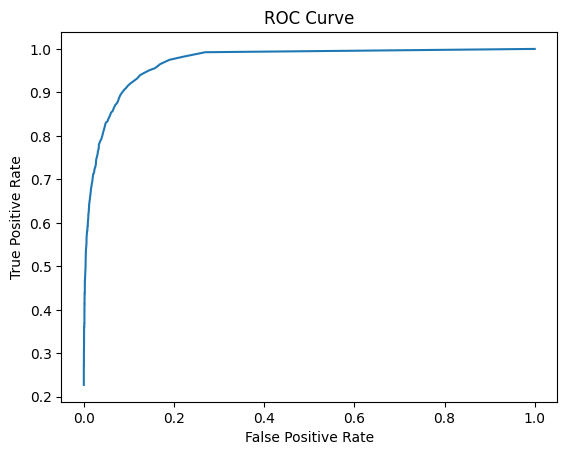

In [19]:
# plot the ROC curve
true_positive_rate, false_positive_rate = ROC_curve(data, labels, thresholds)

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### 3. Determine the threshold that minimizes the probability of error. On the ROC curve, superimpose the true positive and false positive probabilities for this minimum-P(error) threshold. Calculate and report an estimate of the minimum probability of error achievable for this data distribution

In [21]:
# obtain the probability of error for each threshold that is only based on the data and not priors
def probability_of_error(data: np.array, labels: np.array, thresholds: np.array, mu_0: np.array = mu_0, mu_1: np.array = mu_1, sigma_0: np.array = sigma_0, sigma_1: np.array = sigma_1) -> np.array:
    """
    Given data, labels, and a threshold, return the probability of error

    Args:
        data (np.array): the data set
        labels (np.array): the labels for the data set
        thresholds (np.array): the thresholds for the likelihood ratio test
        mu_0 (np.array, optional): the mean of the class 0 Gaussian pdf. Defaults to mu_0.
        mu_1 (np.array, optional): the mean of the class 1 Gaussian pdf. Defaults to mu_1.
        sigma_0 (np.array, optional): the covariance matrix of the class 0 Gaussian pdf. Defaults to sigma_0.
        sigma_1 (np.array, optional): the covariance matrix of the class 1 Gaussian pdf. Defaults to sigma_1.

    Returns:
        np.array: the probability of error for each threshold
    """
    # compute the predicted labels for all thresholds and data points at once
    predictions = np.array([minimum_expected_risk_classification_rule(data, threshold, mu_0, mu_1, sigma_0, sigma_1) for threshold in thresholds])

    # calculate the number of errors for each threshold
    errors = np.sum(predictions != labels, axis=1)

    # compute the probability of error
    p_error = errors / len(data)

    # return the probability of error
    return p_error


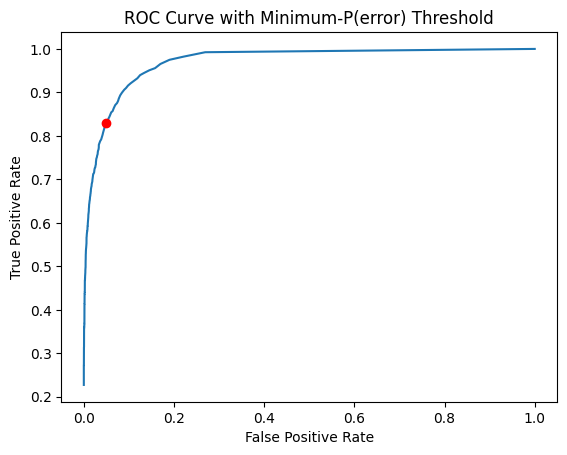

In [22]:
# plot the minimum-P(error) threshold
errors = probability_of_error(data, labels, thresholds)
min_error_index = np.argmin(errors)
min_error = np.min(errors)
min_error_threshold = thresholds[min_error_index]

# plot the ROC curve (previously determined) with the minimum-P(error) threshold
plt.plot(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate[min_error_index], true_positive_rate[min_error_index], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Minimum-P(error) Threshold')
plt.show()

In [34]:
# P(error; threshold) = P(D=1|Y=0)P(Y=0) + P(D=0|Y=1)P(Y=1)
def probability_of_error_optimal(data: np.array, labels: np.array, thresholds: np.array, mu_0: np.array = mu_0, mu_1: np.array = mu_1, sigma_0: np.array = sigma_0, sigma_1: np.array = sigma_1) -> np.array:
    """
    Given data, labels, and an array of thresholds, return the probability of error for each threshold taking into account
    the priors and loss matrix

    Args:
        data (np.array): the data set
        labels (np.array): the labels for the data set
        thresholds (np.array): an array of thresholds for the likelihood ratio test
        mu_0 (np.array, optional): the mean of the class 0 Gaussian pdf. Defaults to mu_0.
        mu_1 (np.array, optional): the mean of the class 1 Gaussian pdf. Defaults to mu_1.
        sigma_0 (np.array, optional): the covariance matrix of the class 0 Gaussian pdf. Defaults to sigma_0.
        sigma_1 (np.array, optional): the covariance matrix of the class 1 Gaussian pdf. Defaults to sigma_1.

    Returns:
        np.array: an array of probabilities of error for each threshold, taking into account the priors and loss matrix
    """
    # compute the predicted labels for all thresholds and data points at once
    predictions = np.array([minimum_expected_risk_classification_rule(data, threshold, mu_0, mu_1, sigma_0, sigma_1) for threshold in thresholds])
    
    # compute the number of errors for each class
    errors_0 = np.sum((labels == 1) & (predictions == 0), axis=1)
    errors_1 = np.sum((labels == 0) & (predictions == 1), axis=1)

    # compute the probability of error for each threshold
    p_errors_0 = errors_0 / len(data)
    p_errors_1 = errors_1 / len(data)

    # compute the probability of error taking into account the priors and loss matrix for each threshold
    p_errors = p_errors_0 * p_0 * loss_matrix[0][1] + p_errors_1 * p_1 * loss_matrix[1][0]

    return p_errors

In [35]:
# determine the theoretical optimal threshold from priors and loss values
errors_optimal = probability_of_error_optimal(data, labels, thresholds)
min_error_index_optimal = np.argmin(errors_optimal)
min_error_optimal = np.min(errors_optimal)
min_error_optimal_threshold = thresholds[min_error_index_optimal]

In [36]:
# print the estimated minimum probability of error
print("The estimated minimum probability of error is: ", min_error_optimal)
# print the empirical selected threshold
print("The empirical selected threshold is: ", min_error_threshold)
# print the theoretical optimal threshold
print("The theoretical optimal threshold is: ", min_error_optimal_threshold)

The estimated minimum probability of error is:  0.03838
The empirical selected threshold is:  2.8000000000000003
The theoretical optimal threshold is:  1.2000000000000002


### Part B: ERM classification using incorrect knowledge of data distribution
#### Assume we know the true class priors, but the class conditional pdfs are both gaussian with true means but the covariance matrices are diagonal (with diagonal entries equal to true variances, but the off-diagonal entries are zero). Analyze the impact of this model mismatch by implementing the ERM classification rule using the incorrect model. Repeat the same steps in part a on the same data set

In [26]:
# set up the diagonal covariance matrices
sigma_0_incorrect = np.array([[2, 0, 0, 0],
                              [0, 1, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 2]])
sigma_1_incorrect = np.array([[1, 0, 0, 0],
                              [0, 2, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 3]])

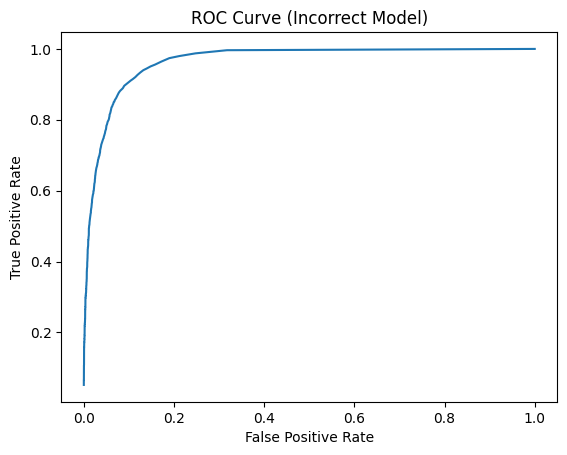

In [28]:
# plot the ROC curve for the incorrect model
true_positive_rate_incorrect, false_positive_rate_incorrect = ROC_curve(data, labels, thresholds, mu_0, mu_1, sigma_0_incorrect, sigma_1_incorrect)

plt.plot(false_positive_rate_incorrect, true_positive_rate_incorrect)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Incorrect Model)')
plt.show()

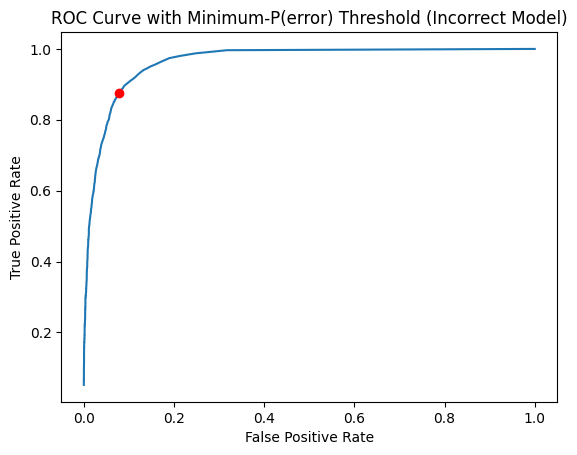

In [29]:
# plot the minimum-P(error) threshold for the incorrect model
errors_incorrect = probability_of_error(data, labels, thresholds, mu_0, mu_1, sigma_0_incorrect, sigma_1_incorrect)
min_error_index_incorrect = np.argmin(errors_incorrect)
min_error_incorrect = np.min(errors_incorrect)
min_error_threshold_incorrect = thresholds[min_error_index_incorrect]

# plot the ROC curve (previously determined) with the minimum-P(error) threshold
plt.plot(false_positive_rate_incorrect, true_positive_rate_incorrect)
plt.plot(false_positive_rate_incorrect[min_error_index_incorrect], true_positive_rate_incorrect[min_error_index_incorrect], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Minimum-P(error) Threshold (Incorrect Model)')
plt.show()

In [30]:
# determine the theoretical optimal threshold from priors and loss values for the incorrect model
errors_optimal_incorrect = probability_of_error_optimal(data, labels, thresholds, mu_0, mu_1, sigma_0_incorrect, sigma_1_incorrect)
min_error_index_optimal_incorrect = np.argmin(errors_optimal_incorrect)
min_error_optimal_incorrect = np.min(errors_optimal_incorrect)
min_error_optimal_threshold_incorrect = thresholds[min_error_index_optimal_incorrect]

In [31]:
# print the estimated minimum probability of error for the incorrect model
print("The estimated minimum probability of error with the incorrect model is: ", min_error_optimal_incorrect)
# print the empirical selected threshold for the incorrect model
print("The empirical selected threshold with the incorrect model is: ", min_error_threshold_incorrect)
# print the theoretical optimal threshold for the incorrect model
print("The theoretical optimal threshold with the incorrect model is: ", min_error_optimal_threshold_incorrect)

The estimated minimum probability of error with the incorrect model is:  0.04036
The empirical selected threshold with the incorrect model is:  2.2
The theoretical optimal threshold with the incorrect model is:  1.0


# TODO: rerun the data on a larger linspace
# TODO: answer the question about how does the empirical vs theoretical compare for both the correct and incorrect models
# TODO: answer the last question about model mismatch